<a href="https://colab.research.google.com/github/arghavanMor/HW_mamba/blob/main/zoology_mamba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Notebook, we present our implementation to:

**Problem1:** Discover the performance gap between mamba and attention architecture

**Problem2:** Close the performance gap
########################################################################
##**Guideline**
* This notebook is a supporting document for implementing the concepts and results in the [presentation report](https://docs.google.com/presentation/d/195nYnjslBa7mfjujT54lI7NlhFGmomwMauxsNm7wvig/edit?usp=sharing). ***This notebook is not completed without the presentation report**.
* To be able to execute the code in this notebook, you need to clone the following repository and go to the path `zoology/HW_experiment/` to find relevant implementations:
https://github.com/arghavanMor/HW_mamba/

* This is a repository sourced from its origin, [Zoology](ttps://github.com/HazyResearch/zoology/). Zoology provides a simple playground for understanding and testing language model architectures on synthetic tasks.

* All the implementations related to Problem1&2 can be also find [here](https://github.com/arghavanMor/HW_mamba/tree/main/zoology/HW_experiments) in the repository.
* Let's start!

############################################################################
##**Problem 1**
First login to your github account, clone the repository, move to the relevant directory and download and install the dependencies.

In [ ]:
#login to git
!git config --global user.email "your email address"

In [ ]:
#or
!git config --global user.name "username"

In [ ]:
#clone the repo
!git clone https://arghavanMor/HW_mamba.git

In [54]:
#move to the directory
!cd --


In [ ]:
pip install -e .[extra,analysis] --use-deprecated=legacy-resolver

Obtaining file:///content/HW_mamba
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.23.4
    Uninstalling pydantic_core-2.23.4:
      Successfully uninstalled pydantic_core-2.23.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.9.2
    Uninstalling pydantic-2.9.2:
      Successfully uninstalled pydantic-2.9.2
  Running setup.py develop for zoology
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.20 requires pydantic>=2.7.0, but you'll have pydantic 2.4.2 which is incompatible.
langchain 0.3.7 requires 

In [ ]:
!python --version


Python 3.10.12


****
Now, we can setup our first model using Zoology. To do so, we first need to initialized the model and training config. [Here](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/HW_experiments/HW_MHA_basic.py) you can find the setup for a basic attention architecture. I also put the code of configing a model as follows to explain more details.

The config starts by setup the train and test data. Class `MQARConfig` in `zoology.data.associative_recall` generate synthetic data for MQAR task, as we already explained the details of the task and the process of synthetic data generation in the presentation.

For training dataset, number of examples equals `num_examples=10_000`, vocabulary size is `vocab_size=128` and length of input sequence sets to `input_seq_len=64`.  `num_kv_pairs": 4` set the number of key-value pairs in the sequnce as explained in the presentation.

Similar setup for test data.

Then, we config our model. Zoology provides the architecture of different language model in `mixers`. For example [here](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/mixers/attention.py). You can check the implementation of multihead attention transformer using pytorch. Number of heads by default is set to `1`. We need to pass some parameters to config the model, before starting to train the model. Parameters such as vocabulary size `vocab_size = 128`, max position embeding, number of heads and also the threshold for dropout layer.

In [ ]:
from zoology.config import TrainConfig, ModelConfig, DataConfig, FunctionConfig, ModuleConfig
from zoology.data.associative_recall import MQARConfig


config = TrainConfig(
    max_epochs=20,
    data=DataConfig(
        train_configs=[MQARConfig(num_examples=10_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
        test_configs=[MQARConfig(num_examples=1_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
    ),
    model=ModelConfig(
        vocab_size=128,
        max_position_embeddings=64,
        sequence_mixer=ModuleConfig(
            name="zoology.mixers.attention.MHA",
            kwargs={"dropout": 0.1, "num_heads": 1}
        )
    ),

)

configs = [config]

After setup the config, we can run the following command to train a basic attention-based transformer with `1` head and also find its accuracy and loss on test data in different epochs (`max_epochs = 20` sets in `TrainingConfig`). For example, for this toy model, the best accuracy is around `0.14`.

In [56]:

!python -m zoology.launch zoology/HW_experiments/HW_MHA_basic.py

Running sweep default2024-11-18-02-32-00 with 1 configs
No logger specified, skipping...
TrainConfig(
    data=DataConfig(
        train_configs=[
            MQARConfig(
                vocab_size=128,
                num_examples=10000,
                input_seq_len=64,
                name='multiquery_ar',
                power_a=0.01,
                num_kv_pairs=8,
                random_non_queries=True,
                include_slices=True
            )
        ],
        test_configs=[
            MQARConfig(
                vocab_size=128,
                num_examples=1000,
                input_seq_len=64,
                name='multiquery_ar',
                power_a=0.01,
                num_kv_pairs=8,
                random_non_queries=True,
                include_slices=True
            )
        ],
        batch_size=32,
        seed=123,
        cache_dir=None,
        force_cache=False
    ),
    model=ModelConfig(
        sequence_mixer=ModuleConfig(
            name=

Now, its time to setup our models for problem 1. We should setup one attention-based and one mamba-based architecure. Same as our implementation for attention-based model, Zoology also provide the architecture setup for [mamba](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/mixers/mamba.py).

Sine we want to train and test both models on a same set of data, we pack the configuration of both architectures in one and then start the training process. [This source file](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/HW_experiments/HW_config.py) contains this configuration.

As we highlighted in the presentation report, we define the vocabulary size `1024`, We vary the input length in `[64, 128, 256, 512]` and the number of key-value pairs in `[4, 8, 16, 32, 64, 128]` to explore different level of complexity for MQAR task. For the test data, we also generate testset with input length and number of key-value pairs not seen during the training. As requested in the problem, with each setup, we generate `20,000` train data and `1000` test data.

The batch size is `128`, the model size changes in `[64, 128, 256]`. The learning rate is in `np.logspace(-3, -1.5, 4)` and number of epoch sets to `20`.


After setup the config of both models and before start the training process, we login into W&B to log all the experiment results for furthur investigation. After login into the `wandba`, we should update the `project_name` and `enitiy` to our relevant project and entity in wandb, in the `TrainConfig` in the [configuration](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/HW_experiments/HW_config.py) setup.


To speed up the process and avoid any crash or intruption, we can train and evaluate each model seperately by removing the name of the other model from list of the models in the [configuration](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/HW_experiments/HW_config.py) setup. To be able to train mamba architecture, we need to install differant packages such as `causal-conv1d` and resolve some dependencies. You can find them in **Draft** section in this notebook.

In [ ]:
pip install wandb

In [ ]:
!wandb login

After training both mamaba and attention-based models, we want to compare their performance on MQAR tasks with different complexities (input length or number of key-value pairs) and discover if there is any gap between the performance of our two toy models on MQAR task.


In the pervious section, we vary the input length in `[64, 128, 256, 512]` and number of key-value pairs in `[4, 8, 16, 32, 64, 128]`. During the validation process, in [train.py](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/train.py), there is a possibility to groupy the `accuracy` on the sythetic test data either by input length, `input_seq_len` or number of key-value pairs `num_kv_pairs`. Then, the result will contain different accuracy on the test set such ash `accuracy/input_seq_len_64` or `accuracy/num_kv_pairs_4` and so on. We can change this setup by varaible `slice_keys` in [trainConfig](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/HW_experiments/HW_config.py) in our configuration by setup its value either to `input_seq_len` or `num_kv_pairs`

In [ ]:
# execute two times. first slice_keys=['num_kv_pairs'], second time slice_keys=['input_seq_len']
!python -m zoology.launch zoology/HW_experiments/HW_config.py

Now its time to plot our results. In the wandb logs for executing each model, we need to find its `lunch_id` and use it here to be able to collect the results of our models on test data. Before running the following code to plot the result, we need to update the `project_name` and `entity name` of our wandb setupin the following code. As we can see in the results, the performance of mamba model decrease significanty by increasing the number key-value pairs in the sequence of input (increasing the complexity of MQAR task). We discuss more details in the presentation report.

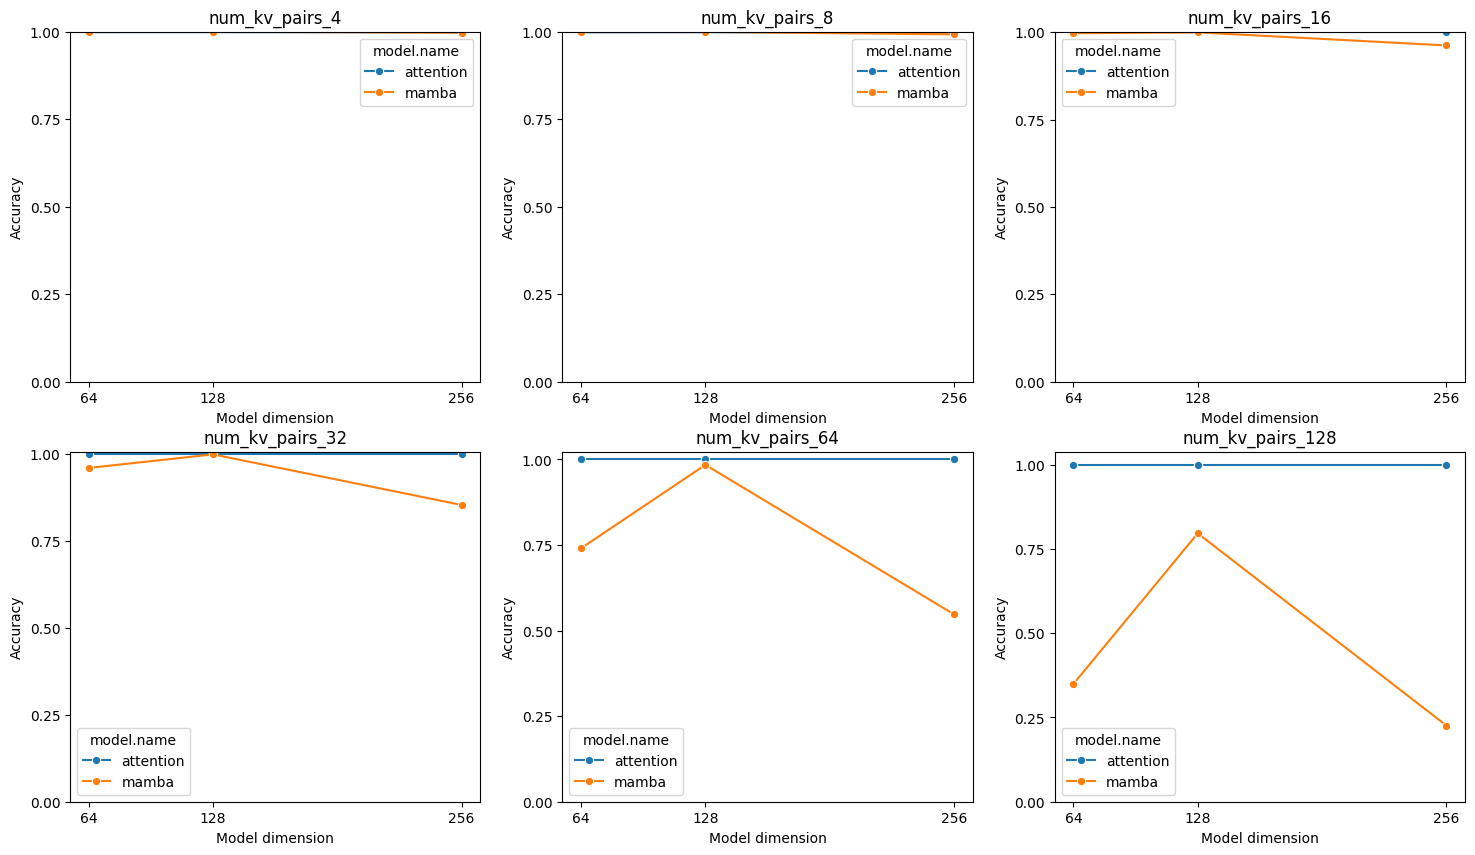

In [59]:
import os
import re

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zoology.analysis.utils import fetch_wandb_runs
import pdb


def plot(
    df: pd.DataFrame,
    max_seq_len: int = 512,
):
    seq_len_key = "data.train_configs.2.input_seq_len"


    accuracy_keys = ["valid/num_kv_pairs/accuracy-4", "valid/num_kv_pairs/accuracy-8", "valid/num_kv_pairs/accuracy-16",
                    "valid/num_kv_pairs/accuracy-32", "valid/num_kv_pairs/accuracy-64", "valid/num_kv_pairs/accuracy-128"]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

    # Iterate through keys and axes
    for ax, accuracy_key in zip(axes.flat, accuracy_keys):
        # Prepare data for the specific accuracy_key
        plot_df = df.groupby([
            "model.name",
            "model.d_model",
            seq_len_key
        ])[accuracy_key].max().reset_index()

        sns.lineplot(
            data=plot_df[plot_df[seq_len_key] <= max_seq_len],
            x="model.d_model",
            y=accuracy_key,
            hue="model.name",
            marker="o",
            ax=ax
        )

        match = re.search(r"valid/([^/]+)/accuracy-(\d+)", accuracy_key)
        if match:
          number = match.group(2)  # Captures "4"
        ax.set_title(f"num_kv_pairs_{number}")
        ax.set_xlabel("Model dimension")
        ax.set_ylabel("Accuracy")
        ax.set_xticks([64, 128, 256])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])


if __name__ == "__main__" :
  df = fetch_wandb_runs(
      launch_id=[
          "default-2024-11-16-05-24-11",
          "default-2024-11-16-20-50-22"
      ],
      project_name="HW_mamba"
  )

  plot(df=df)
  plt.savefig("/content/HW_mamba/results_kv.png")

Now, we plot our results based on the `input sequence length`. As we can see in the second plot, when the sequnce is not very large (i.e 64 or 128), the performance of mamba model at the low model dimension is significantly lower than attention but when the model dimension increases, the performance of mamba can match the attention-based model. However, we the input length increases (up to 512), even in high dimension model, there is a significant gap between the performance of mamba and attention architecture.

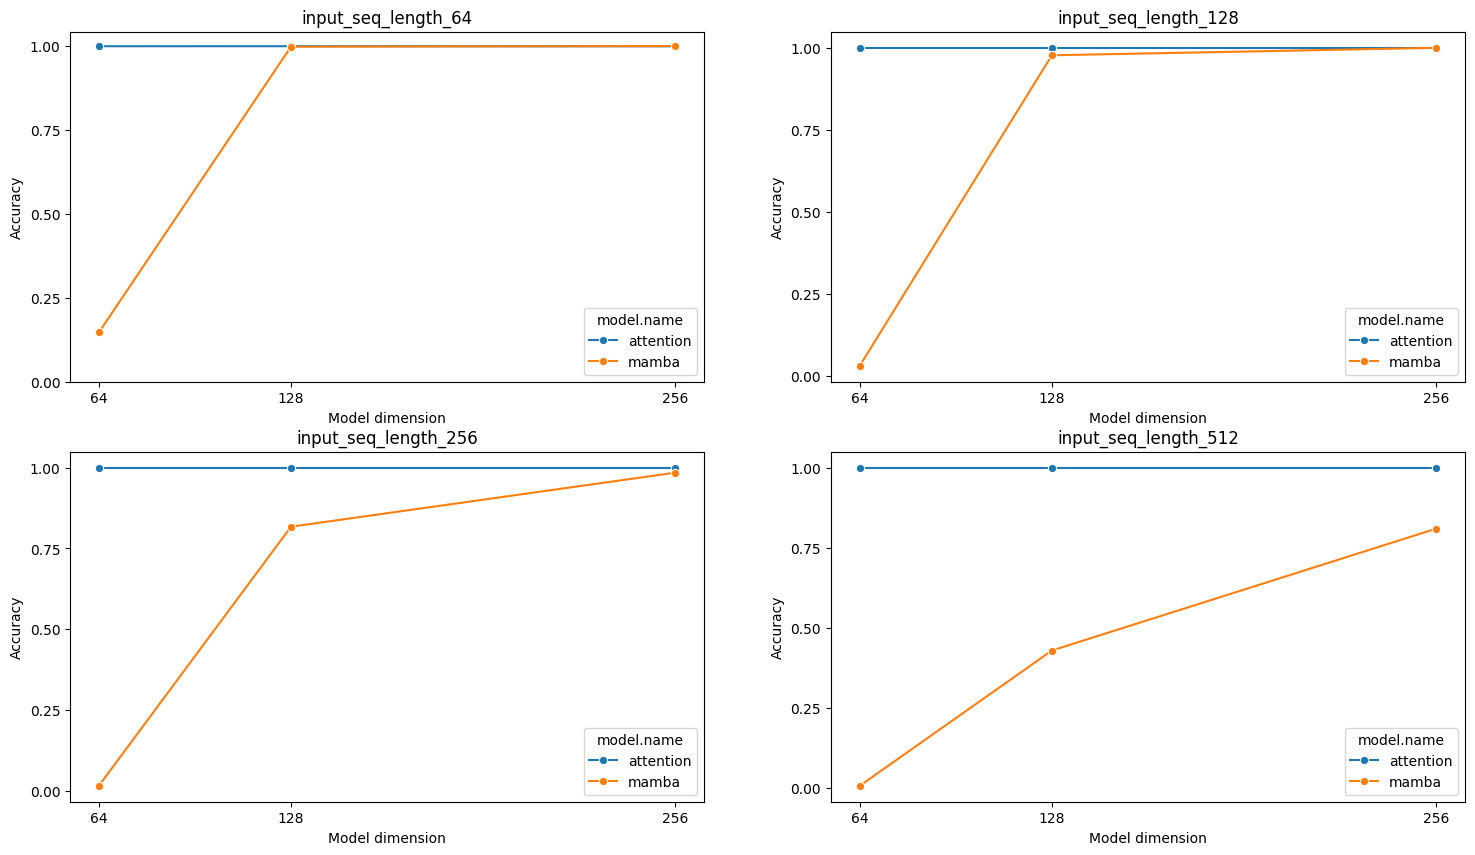

In [60]:

import os
import re

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zoology.analysis.utils import fetch_wandb_runs
import pdb


def plot(
    df: pd.DataFrame,
    max_seq_len: int = 512,
):
    seq_len_key = "data.train_configs.2.input_seq_len"



    accuracy_keys = ["valid/input_seq_len/accuracy-64", "valid/input_seq_len/accuracy-128", "valid/input_seq_len/accuracy-256",
                    "valid/input_seq_len/accuracy-512"]

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))  # 2 rows, 3 columns

    # Iterate through keys and axes
    for ax, accuracy_key in zip(axes.flat, accuracy_keys):
        # Prepare data for the specific accuracy_key
        plot_df = df.groupby([
            "model.name",
            "model.d_model",
            seq_len_key
        ])[accuracy_key].max().reset_index()

        sns.lineplot(
            data=plot_df[plot_df[seq_len_key] <= max_seq_len],
            x="model.d_model",
            y=accuracy_key,
            hue="model.name",
            marker="o",
            ax=ax
        )

        match = re.search(r"valid/([^/]+)/accuracy-(\d+)", accuracy_key)
        if match:
          number = match.group(2)  # Captures "4"
        ax.set_title(f"input_seq_length_{number}")
        ax.set_xlabel("Model dimension")
        ax.set_ylabel("Accuracy")
        ax.set_xticks([64, 128, 256])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])


if __name__ == "__main__" :
  df = fetch_wandb_runs(
      launch_id=[

          "default-2024-11-17-04-29-05",
          "default-2024-11-16-22-09-21"
      ],
      project_name="HW_mamba"
  )

  plot(df=df)
  plt.savefig("/content/HW_mamba/results_length.png")

****
###############################################################################
##**Problem2**
The goal of second problem is to close the gap between Linear architecures like mamba and attention-based models.

In the presentation report, we explained some details about  `attention-to-mamba initialization` technique. Basically, to implement this technique, we need to first initialize (replace) the parameters of mamba (X, B, C) with attention parameters (K, Q, V).


To do so, we need a pre-trained mamba and transformer model. For this case, we can refer to our models that we trained for `problem1`. However, for simplification (learning rate rate, different model size, input_length, etc), I created a seperate [config file](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/HW_experiments/HW_mamba_basic.py) to train a mamba architecture. At the begining of this notebook, we also trained a basic attention based model that we use here.


This time, we need to save our torch model to be able to load it for furthur investigation. To do so, I added the following function into [`train.py`](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/train.py) in the `Trainer` class and call the `save_model` method at the last step of `fit` function in the same class. Due to time limitation, I change the path in the `save_model` method manually to save both `attention` and `mamba` models. However, in future we can pass it as an argument to the `Trainer` class.

```python
def save_model(self, save_dir: str):
        """
           Save the model and tokenizer to the specified directory.
        """
        torch.save(self.model.state_dict(), save_dir)
```

and then call it after fiting the model:

```python
 self.save_model("/content/HW_mamba/attn_model")
 ```


 Now, to start solving problem 2, we can load both models as follow. To be able to creat an instance of the model, we need pass it the model config. To do so, for each model I first, set their config and then load the pre-trained model. By calling `LanguageModel` in Zoology, we can create an instance with any config that it supports.

In [107]:
!python -m zoology.launch zoology/HW_experiments/HW_mamba_basic.py

Running sweep default2024-11-18-04-56-28 with 1 configs
No logger specified, skipping...
TrainConfig(
    data=DataConfig(
        train_configs=[
            MQARConfig(
                vocab_size=128,
                num_examples=10000,
                input_seq_len=64,
                name='multiquery_ar',
                power_a=0.01,
                num_kv_pairs=8,
                random_non_queries=True,
                include_slices=True
            )
        ],
        test_configs=[
            MQARConfig(
                vocab_size=128,
                num_examples=1000,
                input_seq_len=64,
                name='multiquery_ar',
                power_a=0.01,
                num_kv_pairs=8,
                random_non_queries=True,
                include_slices=True
            )
        ],
        batch_size=32,
        seed=123,
        cache_dir=None,
        force_cache=False
    ),
    model=ModelConfig(
        sequence_mixer=ModuleConfig(name='zoology.mixe

In [61]:
from zoology.model import LanguageModel
import torch

In [79]:
#defining the model config same as the config used during the training process.
#We don't need to pass the data for training and test for this config here, but I need more time to figure out how to only pass the model config not the whole data and model setup

from zoology.config import TrainConfig, ModelConfig, DataConfig, FunctionConfig, ModuleConfig
from zoology.data.associative_recall import MQARConfig


att_config = TrainConfig(
    max_epochs=20,
    data=DataConfig(
        train_configs=[MQARConfig(num_examples=10_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
        test_configs=[MQARConfig(num_examples=1_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
    ),
    model=ModelConfig(
        vocab_size=128,
        max_position_embeddings=64,
        sequence_mixer=ModuleConfig(
            name="zoology.mixers.attention.MHA",
            kwargs={"dropout": 0.1, "num_heads": 1}
        )
    ),

)

configs = [config]

In [80]:
#creating an instance of an attention-based model
att_model = LanguageModel(config=att_config.model)

In [72]:
#loading the model
att_model.load_state_dict(torch.load("/content/HW_mamba/attn_model"))

<All keys matched successfully>

As we can see in the `eval` result, our model has two layers, with an attention layer, `MHA` and and MLP layer, `MLP`. For each layer, we need to collect its attention parameters from `Wqkv` and use it to inialize the parameter of mamba.

In [74]:
#shows the model architecture
att_model.eval()

LanguageModel(
  (backbone): LMBackbone(
    (embeddings): TokenEmbeddings(
      (word_embeddings): Embedding(128, 128)
      (position_embeddings): Embedding(64, 128)
    )
    (layers): ModuleList(
      (0): TransformerBlock(
        (sequence_mixer): MHA(
          (Wqkv): Linear(in_features=128, out_features=384, bias=True)
          (inner_attn): SelfAttention()
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (state_mixer): MLP(
          (fc1): Linear(in_features=128, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=128, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout2): Dropout(p=0.0, inplace=False)
        (drop_path2): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
     

In [81]:
#for example with this code we can have access to the MLP layer of the model
# To apply the knowledge distillization step, we need to freez MLP layer
mlp_layer = att_model.backbone.layers[0].state_mixer
print(mlp_layer)

MLP(
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
)


In [100]:
#Collecting the three attention vectors from our pretrained model
#we need them for initialzing the parameters of mamba model

source_wqkv = att_model.backbone.layers[0].sequence_mixer.Wqkv
Q= source_wqkv.weight[:128, :]
K= source_wqkv.weight[128:256, :]
V= source_wqkv.weight[256:, :]

We repeat the same process to load our mamba model for furthur investigation.

In [104]:
from zoology.config import TrainConfig, ModelConfig, DataConfig, FunctionConfig, ModuleConfig
from zoology.data.associative_recall import MQARConfig


config_mamba = TrainConfig(
    max_epochs=20,
    data=DataConfig(
        train_configs=[MQARConfig(num_examples=10_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
        test_configs=[MQARConfig(num_examples=1_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
    ),

    model = ModelConfig(
        block_type="MambaBlock",
        vocab_size=128,
        max_position_embeddings=0,
        n_layers=2,
        sequence_mixer=dict(
            name="zoology.mixers.mamba.Mamba",
            kwargs={"d_state": 16}),
        ),
        name="mamba",

)

configs = [config]

In [105]:
model_mamba = LanguageModel(config=config_mamba.model)

In [108]:
model_mamba.load_state_dict(torch.load("/content/HW_mamba/mamba_model"))

<All keys matched successfully>

Our pre-trained mamba model also has two layers, both with same setup. In this pretrained model, we need to initialize its paramemters (in_proj, x_proj, dt_proj) with K, Q and V.

In [109]:
model_mamba.eval()

LanguageModel(
  (backbone): LMBackbone(
    (embeddings): TokenEmbeddings(
      (word_embeddings): Embedding(128, 128)
    )
    (layers): ModuleList(
      (0-1): 2 x MambaBlock(
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
        (norm): RMSNorm()
      )
    )
    (drop_f): Dropout(p=0.0, inplace=False)
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=128, bias=False)
)

In [ ]:
test= model_mamba.backbone.layers[0].mixer
print(test)

Mamba(
  (in_proj): Linear(in_features=128, out_features=512, bias=False)
  (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
  (act): SiLU()
  (x_proj): Linear(in_features=256, out_features=40, bias=False)
  (dt_proj): Linear(in_features=8, out_features=256, bias=True)
  (out_proj): Linear(in_features=256, out_features=128, bias=False)
)


In [97]:
#I need to investigate more, but probebly weight of in_proj can be refer as A, wight of conv1d as B and wight of out_proj as C
A= model_mamba.backbone.layers[0].mixer.in_proj.weight
B =model_mamba.backbone.layers[0].mixer.conv1d.weight
C= model_mamba.backbone.layers[0].mixer.out_proj.weight
print(C)

Parameter containing:
tensor([[ 0.0190,  0.0321, -0.0158,  ..., -0.0064,  0.0047,  0.0190],
        [-0.0154,  0.0285, -0.0233,  ...,  0.0253,  0.0278,  0.0092],
        [-0.0107,  0.0628, -0.0505,  ..., -0.0104, -0.0191,  0.0840],
        ...,
        [-0.0035, -0.0416, -0.0038,  ...,  0.0193, -0.0202,  0.0492],
        [-0.0256, -0.0148, -0.0202,  ..., -0.0028, -0.0057,  0.0272],
        [ 0.0168, -0.0055,  0.0071,  ...,  0.0104, -0.0221,  0.0432]],
       requires_grad=True)


To complete answering `problem 2`, we may also need to update the implementation of mamba architecutre [here](https://github.com/arghavanMor/HW_mamba/blob/main/zoology/mixers/mamba.py) where we are initializing the parameters.


After updating the the parameters, we should apply one of the distilling steps to finetune the new model (attention initiliazed mamba) with etheir `KL-divergence` or `SeqKD`. More details are in the presentation report.
****


***Draft section (not part of the solutions to the problems)***

This section is a draft on different installation and dependency conflict or run time bug resolving that may help in replicating this notebook. In case of a bug or error, maybe can search in this draft section to find a solution to solve it.

In [ ]:
pip install wandb

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install triton

In [ ]:
cd ..

/content


To push changes to github

In [117]:
!git add .

In [118]:
!git commit -m "using hybrid model to mix wity attention based model with convBase"

[main f96c15d] using hybrid model to mix wity attention based model with convBase
 1 file changed, 2 insertions(+)


In [119]:
!git push origin main

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 562 bytes | 562.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/arghavanMor/HW_mamba.git
   9efddc3..f96c15d  main -> main


In [ ]:
!git clone https://github.com/Dao-AILab/causal-conv1d.git

Cloning into 'causal-conv1d'...
remote: Enumerating objects: 343, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 343 (delta 107), reused 82 (delta 82), pack-reused 218 (from 1)
Receiving objects: 100% (343/343), 81.62 KiB | 189.00 KiB/s, done.
Resolving deltas: 100% (176/176), done.


In [ ]:
cd causal-conv1d

/content/HW_mamba/causal-conv1d


In [ ]:
rm -rf *.egg.info build

In [ ]:
!git checkout v1.4.0

Note: switching to 'v1.4.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at f8c2467 Bump to v1.4.0


In [ ]:
!export CAUSAL_CONV1D_FORCE_BUILD=TRUE

In [ ]:
pip install .

Processing /content/HW_mamba/causal-conv1d
  Preparing metadata (setup.py) ... done
  Created wheel for causal_conv1d: filename=causal_conv1d-1.4.0-cp310-cp310-linux_x86_64.whl size=103612780 sha256=b37d1d2fcbb3d79446fb7f08690a6136da3c92be0ca2aab1629a1ab3d451ce9e
  Stored in directory: /root/.cache/pip/wheels/aa/b8/75/afa073c714a371e7f79e6e0875bb3215025df315ae036574d5
Successfully built causal_conv1d
  Attempting uninstall: causal_conv1d
    Found existing installation: causal-conv1d 1.1.1
    Uninstalling causal-conv1d-1.1.1:
      Successfully uninstalled causal-conv1d-1.1.1


In [ ]:
pip install setuptools wheel packaging

In [ ]:
!pip install mamba_ssm

In [ ]:
cd ..

/content


In [ ]:
!git clone https://github.com/state-spaces/mamba.git

Cloning into 'mamba'...
remote: Enumerating objects: 648, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 648 (delta 228), reused 206 (delta 196), pack-reused 348 (from 1)
Receiving objects: 100% (648/648), 1.55 MiB | 4.05 MiB/s, done.
Resolving deltas: 100% (340/340), done.


In [ ]:
cd mamba

/content/mamba


In [ ]:
rm -rf *.egg.info build

In [ ]:
!git checkout v2.2.2 # current latest version tag

Note: switching to 'v2.2.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 8ffd905 Fix varlen generation by passing seq_idx to causal_conv1d


In [ ]:
!export MAMBA_FORCE_BUILD=TRUE

In [ ]:
cd --

/content/zoology


In [ ]:
pip install .

Processing /content/mamba
  Preparing metadata (setup.py) ... done
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=343412612 sha256=150be68a91b3444b35ee2cda6a4790aaf83711009a8bf8e91afc7a316b091df6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7nzcq2ay/wheels/fb/bd/db/47d39b5aa5f1c5ccf671710c66e7a084dd82fb317f85f52625
Successfully built mamba_ssm
  Attempting uninstall: mamba_ssm
    Found existing installation: mamba-ssm 1.2.0.post1
    Uninstalling mamba-ssm-1.2.0.post1:
      Successfully uninstalled mamba-ssm-1.2.0.post1


In [ ]:
!pip install https://github.com/Dao-AILab/causal-conv1d/releases/download/v1.4.0/causal_conv1d-1.4.0+cu118torch2.0cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.6/103.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 13.6 MB/s eta 0:00:00


In [ ]:
pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 590.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu121
    Uninstalling torchaudio-2.5.1+cu121:
      Successfully uninstalled torchaudio-2.5.1+cu121


In [ ]:
pip install causal_conv1d==1.1.1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 kB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 19.8 MB/s eta 0:00:00
  Created wheel for causal_conv1d: filename=causal_conv1d-1.1.1-cp310-cp310-linux_x86_64.whl size=13531321 sha256=f572458de281ed15fbd6f9262d44d66591416c7a903c4da699ed4d70b3cf5a83
  Stored in directory: /root/.cache/pip/wheels/4f/9e/69/9060a1871f461dfca87b667350f5728d44c555f98dacaf04ff
  Created wheel for buildtools: f

In [ ]:
pip install mamba-ssm==1.2.0.post1

  Preparing metadata (setup.py) ... done
  Created wheel for mamba-ssm: filename=mamba_ssm-1.2.0.post1-cp310-cp310-linux_x86_64.whl size=146670262 sha256=d9ceab70d6a454cdc304428c92eb9cca730b5f200192fd8a73327728b666c84a
  Stored in directory: /root/.cache/pip/wheels/22/6e/60/ddd5c574b5793a30028f2cabdacd2a3ec2276edaaa8c00fd35
Successfully built mamba-ssm


In [ ]:
!python -m zoology.launch zoology/experiments/arxiv24_based_figure2/HW_config.py

Running sweep default2024-11-17-04-29-05 with 12 configs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: moradi-arghavan (llms_argh). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.6
wandb: Run data is saved locally in /content/HW_mamba/wandb/run-20241117_042905-m67elgv5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mamba-lr1.0e-03
wandb: ⭐️ View project at https://wandb.ai/llms_argh/HW_mamba
wandb: 🚀 View run at https://wandb.ai/llms_argh/HW_mamba/runs/m67elgv5
TrainConfig(
    data=DataConfig(
        train_configs=[
            MQARConfig(
                vocab_size=1024,
                num_examples=20000,
                input_seq_len=64,
                name='multiquery_ar',
                power_a=0.01,
                num_kv_pairs=4,
                random_non_queries=True,
                include_slices=True
            ),

In [ ]:
#to solve AssertionError: libcuda.so cannot found!
!echo /usr/lib64-nvidia/ >/etc/ld.so.conf.d/libcuda.conf; ldconfig

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is

In [ ]:
cd HW_mamba


/content/HW_mamba


In [ ]:
!python -m zoology.launch zoology/experiments/arxiv24_based_figure2/configs.py

Running sweep default2024-11-17-03-55-40 with 16 configs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: moradi-arghavan. Use `wandb login --relogin` to force relogin
wandb: ERROR failed to upsert bucket: returned error 403 Forbidden: {"errors":[{"message":"permission denied","path":["upsertBucket"],"extensions":{"code":"PERMISSION_ERROR"}}],"data":{"upsertBucket":null}}
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/content/HW_mamba/zoology/launch.py", line 86, in <module>
    main()
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1078, in main
   

In [ ]:
!python -m zoology.launch zoology/analysis/paper/HW_figure2.py

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/content/zoology/zoology/launch.py", line 86, in <module>
    main()
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 783, in invoke
    return __callback(*args, **kwargs)
  File "/content/zoology/zoology/launch.py", line 44, in main
    configs = config_module.configs
AttributeError: module 'config_module' has no attribute 'configs'


data.train_configs.2.input_seq_len


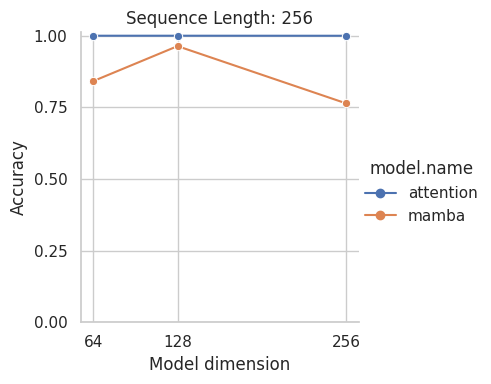

In [ ]:
import os

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zoology.analysis.utils import fetch_wandb_runs
import pdb


def plot(
    df: pd.DataFrame,
    max_seq_len: int = 512,
):
    seq_len_key = "data.train_configs.2.input_seq_len"
   # kv_pairs = "data.train_configs.0.num_kv_pairs"
    print(seq_len_key)

    plot_df = df.groupby([
        "model.name",
        "model.d_model",
        seq_len_key
    ])["accuracy/valid_4"].max().reset_index()
    #breakpoint()
    #pdb.set_trace()
   # run_dir = "/var/cr05_data/sim_data/code/petting-zoo/"
    sns.set_theme(style="whitegrid")
    g = sns.relplot(
        data=plot_df[plot_df[seq_len_key] <= max_seq_len],
        y="valid/accuracy",
        col=seq_len_key,
        x="model.d_model",
        hue="model.name",
        kind="line",
        marker="o",
        height=4,
        aspect=1,
    )

    g.set( ylabel="Accuracy", xlabel="Model dimension")

    # Set custom x-ticks
    ticks = [64, 128, 256] # Modify this list as needed
    for ax in g.axes.flat:
        ax.set_xticks(ticks)

        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter()) # This will keep the tick labels as integers rather than in scientific notation

    # Set custom y-ticks
    y_ticks = [0, 0.25, 0.5, 0.75, 1.0]
    for ax in g.axes.flat:
        ax.set_yticks(y_ticks)

    for ax, title in zip(g.axes.flat, g.col_names):
        ax.set_title(f"Sequence Length: {title}")


if __name__ == "__main__" :
    df = fetch_wandb_runs(
        launch_id=[
            # "default-2023-10-25-22-20-38",
            # "default-2023-10-26-19-09-31",
            # "default-2023-10-27-04-13-56",
            # "default-2023-10-29-17-31-26",
            # "default-2023-11-12-00-31-44",
            # "default-2023-11-13-00-31-15",
            # "default-2023-11-13-00-42-27"

            # "default-2024-02-08-20-16-21"
            # "default-2024-02-08-23-04-42"
            "default-2024-11-16-05-24-11",
            "default-2024-11-16-20-50-22"
        ],
        project_name="HW_mamba"
    )
    #pdb.set_trace()
    # df["data.input_seq_len"] = df["data.input_seq_len"].fillna(df["data.0.input_seq_len"])
    plot(df=df)
    plt.savefig("/content/HW_mamba/results.png")


In [ ]:
import re

# Input string
input_string = "valid/num_kv_pairs/accuracy-4"

# Extract using regular expressions
match = re.search(r"valid/([^/]+)/accuracy-(\d+)", input_string)
if match:
    num_kv_pairs = match.group(1)  # Captures "num_kv_pairs"
    number = match.group(2)  # Captures "4"
    print(f"num_kv_pairs: {num_kv_pairs}, number: {number}")

num_kv_pairs: num_kv_pairs, number: 4


In [ ]:
from zoology.analysis.utils import fetch_wandb_runs
df = fetch_wandb_runs(
        launch_id=[
            # "default-2023-10-25-22-20-38",
            # "default-2023-10-26-19-09-31",
            # "default-2023-10-27-04-13-56",
            # "default-2023-10-29-17-31-26",
            # "default-2023-11-12-00-31-44",
            # "default-2023-11-13-00-31-15",
            # "default-2023-11-13-00-42-27"

            # "default-2024-02-08-20-16-21"
            # "default-2024-02-08-23-04-42"
           # "default-2024-11-16-05-24-11"
            "default-2024-11-16-05-24-11"
        ],
        project_name="HW_mamba"
    )
print(df.shape)
print(df[['model.d_model','valid/num_kv_pairs/accuracy-128','data.train_configs.0.input_seq_len','data.batch_size.1']])
column_names=df.columns
print(column_names)
columns_with_data = [col for col in column_names if "valid/accuracy" in col.lower()]
print(columns_with_data)

(36, 914)
    model.d_model  valid/num_kv_pairs/accuracy-128  \
0              64                         0.004453   
1              64                         0.007766   
2              64                         0.002031   
3              64                         0.103977   
4              64                         0.004219   
5              64                         0.006523   
6              64                         0.002617   
7              64                         0.349297   
8              64                         0.006586   
9              64                         0.004664   
10             64                         0.005219   
11             64                         0.272164   
12            128                         0.068070   
13            128                         0.009445   
14            128                         0.007406   
15            128                         0.383234   
16            128                         0.006367   
17            128 

In [ ]:
!echo /usr/lib64-nvidia/ >/etc/ld.so.conf.d/libcuda.conf; ldconfig

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is

In [ ]:
from zoology.config import TrainConfig, ModelConfig, DataConfig, ModuleConfig, FunctionConfig
from zoology.data.associative_recall import MQARConfig

config = TrainConfig(
    max_epochs=20,
    data=DataConfig(
        train_configs=[MQARConfig(num_examples=10_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
        test_configs=[MQARConfig(num_examples=1_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
    ),
    model=ModelConfig(
        vocab_size=128,
        sequence_mixer=ModuleConfig(name = "zoology.mixers.attention.MHA")
    ),
)
configs = [config]

In [ ]:
import torch

In [ ]:
from zoology.config import TrainConfig, ModelConfig, DataConfig, ModuleConfig, FunctionConfig

fn_config = FunctionConfig(name="torch.sort", kwargs={"descending": True})
fn = fn_config.instantiate()
fn(torch.tensor([2,4,3])) # [4, 3, 2]

torch.return_types.sort(
values=tensor([4, 3, 2]),
indices=tensor([1, 2, 0]))

In [ ]:
fn_config= FunctionConfig(
            name="zoology.data.associative_recall.multiquery_ar",
            kwargs={"num_kv_pairs": 4}
        )
fn = fn_config.instantiate()
print(fn)

functools.partial(<function multiquery_ar at 0x7f2b4cdf3760>, num_kv_pairs=4)


In [ ]:
import numpy as np

from zoology.config import TrainConfig, ModelConfig, DataConfig, FunctionConfig, ModuleConfig
from zoology.data.associative_recall import MQARConfig

configs = []

for lr in np.logspace(-4, -2, 10):

  config = TrainConfig(
      max_epochs=20,
      data=DataConfig(
      train_configs=[MQARConfig(num_examples=20_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
      test_configs=[MQARConfig(num_examples=1_000, vocab_size=128, input_seq_len=64, kwargs={"num_kv_pairs": 4})],
      ),
      model=ModelConfig(
         vocab_size=256,
         max_position_embeddings=64,
         sequence_mixer=ModuleConfig(
               name="zoology.mixers.attention.MHA",
               kwargs={"dropout": 0.1, "num_heads": 1})
         ),
      learning_rate=lr
      )
  configs.append(config)